In [1]:
from models.siren import SIREN
import torch
from utils import Implicit1DWrapper, dict2cuda, reset_session
from loss import control_variate_loss, autoInt_loss
from torch.utils.data import DataLoader
import math
from monte_carlo import cv_monte_carlo_integration as eval_ncv
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


In [2]:
import torch
import numpy as np

# Define the target function and its integral
def f(x):
    return torch.sin(x)

def true_integral(a, b):
    return -torch.cos(b) + torch.cos(a)

# AutoInt training
def train_autoint(f, domain, epochs, device=device, print_loss_every =50,  num_samples=1000):
    b, a = domain
    dataset = Implicit1DWrapper([b,a], fn=f, \
                                sampling_density=num_samples, train_every=1)

    dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                            pin_memory=True, num_workers=0)
    # bounds_tensor = torch.tensor([[b], [a]], dtype=torch.float32).to(device)
    model = SIREN
    loss_fn = autoInt_loss()
    cv_fn, cv_integral, net = reset_session(model, device)
    optimizer = torch.optim.Adam(lr=5e-4, params=net.parameters(),amsgrad=True)

    losses = []
    print(f'training autoint Epochs ={epochs}, lr = {5e-4}, samp_den = {num_samples}')


    for e in range(epochs):
        for step, (input, gt) in enumerate(dataloader):
            input = dict2cuda(input)
            gt = dict2cuda(gt)
            
            gradnet_output = cv_fn.compute_graph_fast2({'x_coords': input['coords'],
                                                                    'params': None})
            # integralnet_output = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
            loss = loss_fn(gradnet_output, gt['func'])
            
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
        if not e % print_loss_every:
            print(f"{e}/{epochs}: loss={loss}")
    return cv_integral, cv_fn, losses

# NCV implementation
def train_ncv(f, domain, epochs, device=device, print_loss_every =50,  num_samples=1000):
    
    b,a  = domain
    dataset = Implicit1DWrapper([b,a], fn=f, \
                                sampling_density=num_samples, train_every=1)

    dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                            pin_memory=True, num_workers=0)
    bounds_tensor = torch.tensor([[b], [a]], dtype=torch.float32).to(device)
    model = SIREN
    loss_fn = control_variate_loss(U = a, L = b)
    cv_fn, cv_integral, net = reset_session(model, device)
    optimizer = torch.optim.Adam(lr=5e-4, params=net.parameters(),amsgrad=True)

    losses = []

    print(f'training ncv Epochs ={epochs}, lr = {5e-4}, samp_den = {num_samples}')
    for e in range(epochs):
        for step, (input, gt) in enumerate(dataloader):
            input = dict2cuda(input)
            gt = dict2cuda(gt)
            
            gradnet_output = cv_fn.compute_graph_fast2({'x_coords': input['coords'],
                                                                    'params': None})
            integralnet_output = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
            loss = loss_fn(integralnet_output, gradnet_output, gt['func'])
            
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
        if not e % print_loss_every:
            print(f"{e}/{epochs}: loss={loss}")
    return cv_integral, cv_fn, losses


def eval_autoint(cv_integral, domain):
    b,a  =domain
    bounds_tensor = torch.tensor([[b], [a]], dtype=torch.float32).to(device)
    with torch.no_grad():
        lower, upper = cv_integral.compute_graph_fast2({'x_coords': bounds_tensor ,'params': None})
    integral = upper - lower
    return integral.item()


# Evaluation
domain = [0,np.pi]
integral_net, grad_net, loss_autoint = train_autoint(f, domain, epochs=1000)
cv_integral, cv_fn, loss_cv = train_ncv(f, domain, epochs=1000)



Creating session: 320346137
Creating session: 320346209
training autoint Epochs =1000, lr = 0.0005, samp_den = 1000
0/1000: loss=0.5043514966964722
50/1000: loss=0.03755620867013931
100/1000: loss=0.0006404751329682767
150/1000: loss=6.5205204009544104e-06
200/1000: loss=2.5153607566608116e-05
250/1000: loss=0.0009284121915698051
300/1000: loss=4.7426715354959015e-06
350/1000: loss=8.364319796783093e-07
400/1000: loss=6.446577458518732e-07
450/1000: loss=5.539073413274309e-07
500/1000: loss=4.8575418531982e-07
550/1000: loss=4.3094698298773437e-07
600/1000: loss=3.851844496693957e-07
650/1000: loss=3.4933336223730294e-07
700/1000: loss=0.0028327370528131723
750/1000: loss=5.869229426025413e-06
800/1000: loss=5.915177325732657e-07
850/1000: loss=4.3622586076708103e-07
900/1000: loss=3.637745180640195e-07
950/1000: loss=3.1316579907070263e-07
Creating session: 320347121
Creating session: 274264755
training ncv Epochs =1000, lr = 0.0005, samp_den = 1000
0/1000: loss=0.9762408137321472


/Users/sekiro/miniconda3/envs/autoint/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 3000, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


50/1000: loss=0.03550408035516739
100/1000: loss=0.01697140373289585
150/1000: loss=0.01685570925474167
200/1000: loss=1.1034483909606934
250/1000: loss=0.8413432240486145
300/1000: loss=0.8702278137207031
350/1000: loss=0.8786266446113586
400/1000: loss=1.12995445728302
450/1000: loss=0.9291626214981079
500/1000: loss=0.8630994558334351
550/1000: loss=1.0096219778060913
600/1000: loss=0.9797677397727966
650/1000: loss=0.8751761317253113
700/1000: loss=1.284982442855835
750/1000: loss=1.0265147686004639
800/1000: loss=0.9398676156997681
850/1000: loss=1.0859242677688599
900/1000: loss=1.0147523880004883
950/1000: loss=0.880085289478302


Text(0, 0.5, 'Frequency')

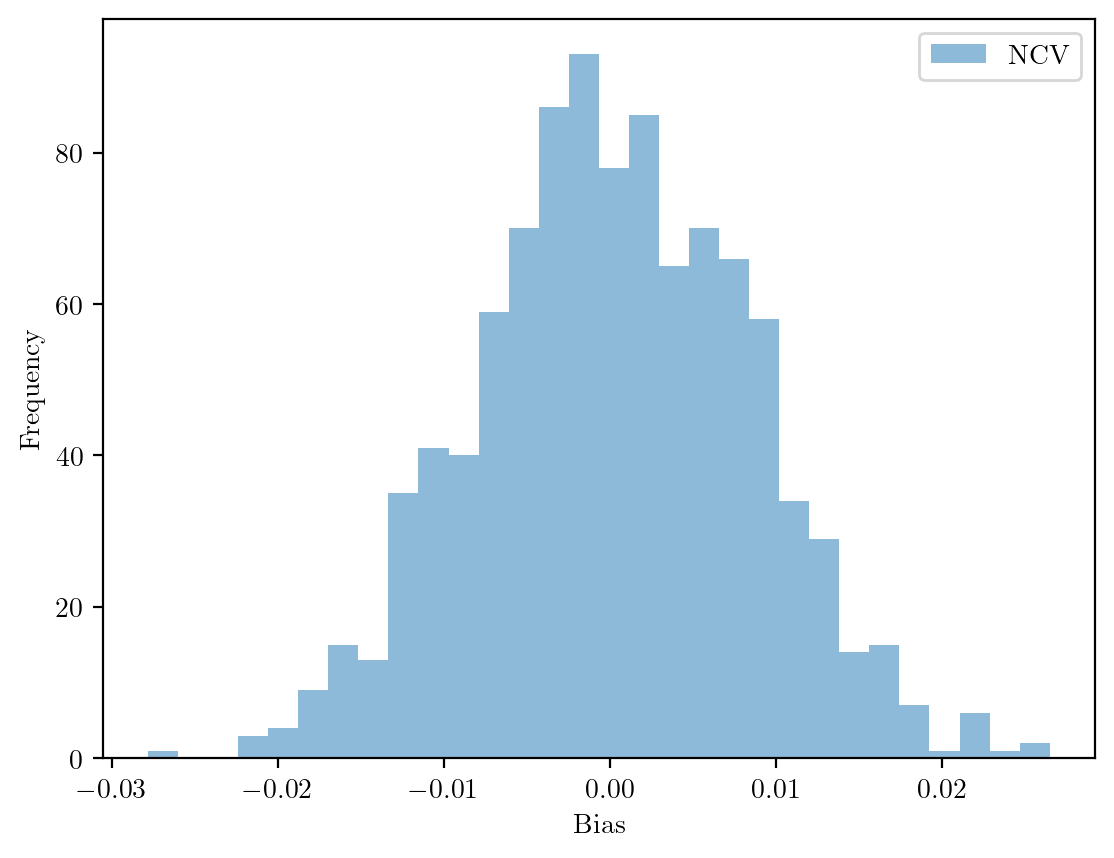

In [83]:
# true_value = true_integral(torch.tensor(0), torch.tensor(np.pi))
# from utils import cv_monte_carlo_integration as eval_ncv
def trials(noise_level =0.1,  runs=1000):
    autoint_bias =[]
    ncv_bias_10k = []
    for i in range(runs):
        base_domain = [0, np.pi]
        noise = np.random.randn() * noise_level
        new_domain = [base_domain[0] + noise, base_domain[1] + noise]
        new_domain[0] = min(max(new_domain[0], 0), np.pi)
        new_domain[1] = min(max(new_domain[1], 0), np.pi)
        true_value = true_integral(torch.tensor(new_domain[0]), torch.tensor(new_domain[1]))

        # autoint_est = eval_autoint(integral_net, new_domain)
        g_integral = eval_autoint(cv_integral, new_domain)
        ncv_est_mean = eval_ncv(f,cv_fn, g_integral=g_integral, domain = new_domain, n_samples=10000, repeat=False)
        # autoint_bias.append((autoint_est - true_value))
        ncv_bias_10k.append(ncv_est_mean - true_value)
    return autoint_bias, ncv_bias_10k

# print("True Value:", true_value)
# print("AutoInt Estimate:", autoint_est)
# print(f"NCV Estimate : {ncv_est_mean} std: {ncv_est_std}")


# print("AutoInt Bias:", abs(autoint_est - true_value))
# print("NCV Bias:", abs(ncv_est_mean - true_value))
from matplotlib import pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure( dpi=200)
autoint_bias, ncv_bias_10k = trials(runs=1000)
# plt.hist(autoint_bias, bins=30, alpha=0.5, label='AutoInt')
plt.hist(ncv_bias_10k, bins=30, alpha=0.5, label='NCV')
plt.legend(loc='upper right')
plt.xlabel('Bias')
plt.ylabel('Frequency')

# plt.show()



In [84]:
ncv_bias

[tensor(0.0244),
 tensor(-0.0327),
 tensor(0.0294),
 tensor(-0.0568),
 tensor(0.0263),
 tensor(0.0333),
 tensor(0.0073),
 tensor(-0.0289),
 tensor(-0.0108),
 tensor(0.0049),
 tensor(0.0503),
 tensor(0.0249),
 tensor(0.0098),
 tensor(-0.0044),
 tensor(-0.0118),
 tensor(-0.0033),
 tensor(0.0045),
 tensor(0.0026),
 tensor(0.0216),
 tensor(-0.0137),
 tensor(0.0294),
 tensor(0.0488),
 tensor(0.0103),
 tensor(-0.0085),
 tensor(-0.0020),
 tensor(0.0029),
 tensor(-0.0167),
 tensor(0.0011),
 tensor(-0.0276),
 tensor(0.0040),
 tensor(0.0421),
 tensor(-0.0298),
 tensor(0.0035),
 tensor(-0.0086),
 tensor(0.0230),
 tensor(0.0022),
 tensor(0.0560),
 tensor(-0.0048),
 tensor(-0.0225),
 tensor(-0.0179),
 tensor(0.0292),
 tensor(-0.0102),
 tensor(-0.0443),
 tensor(0.0195),
 tensor(-0.0458),
 tensor(-0.0033),
 tensor(-0.0171),
 tensor(-0.0265),
 tensor(0.0563),
 tensor(-0.0368),
 tensor(-0.0331),
 tensor(0.0006),
 tensor(-0.0150),
 tensor(-0.0075),
 tensor(-0.0122),
 tensor(0.0212),
 tensor(-0.0222),
 t

/Users/sekiro/miniconda3/envs/autoint/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sekiro/miniconda3/envs/autoint/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


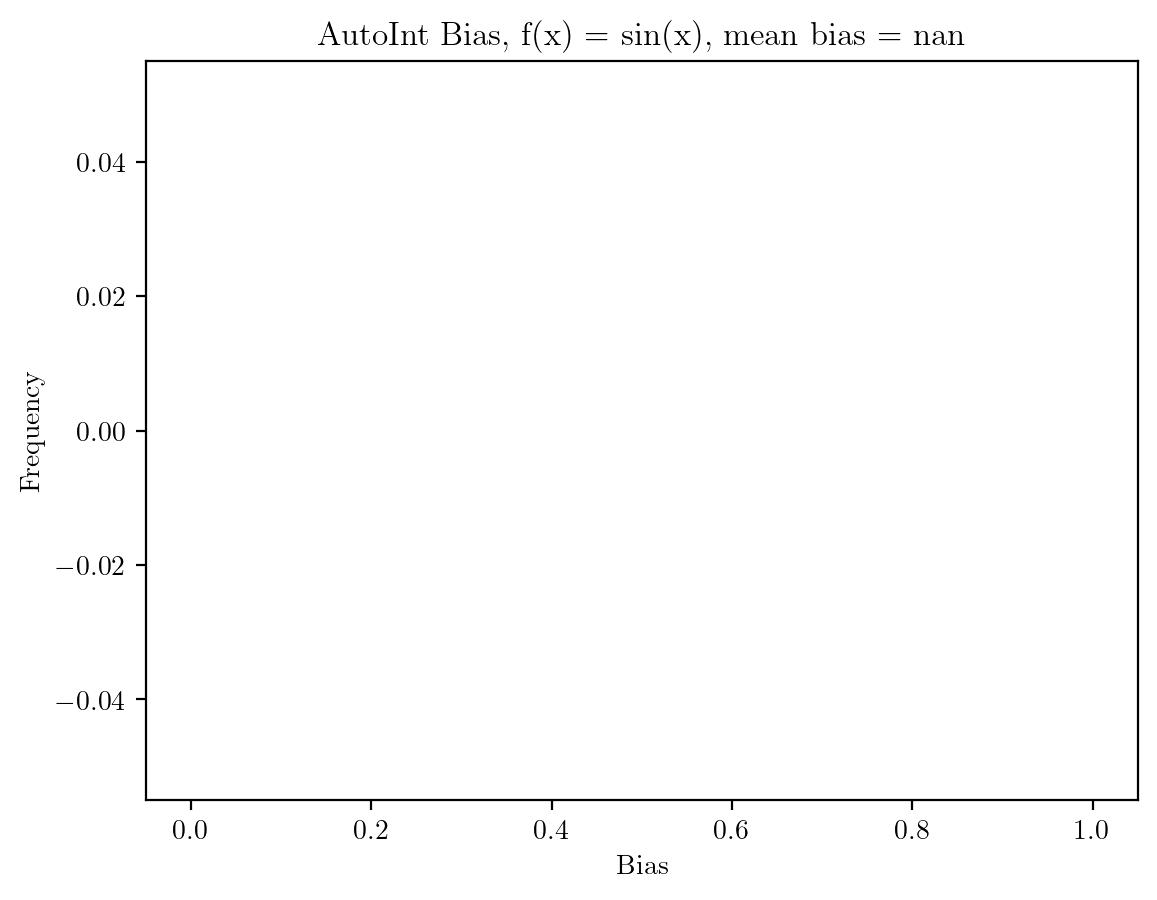

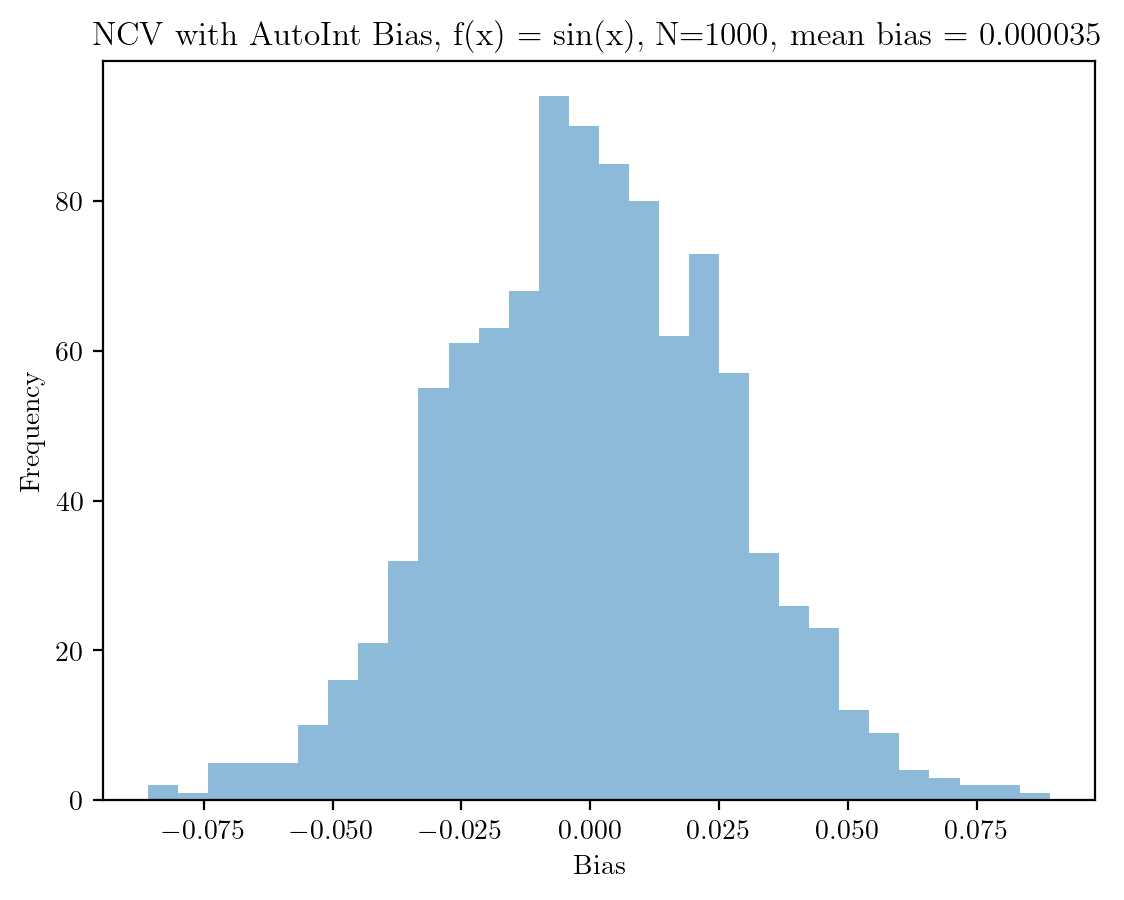

In [88]:
from matplotlib import pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure( dpi=200)
# autoint_bias, ncv_bias = trials(true_value, runs=1000)
plt.hist(autoint_bias, bins=30, alpha=0.5, label='AutoInt')
# plt.legend(loc='upper right')
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.title(f'AutoInt Bias, f(x) = sin(x), mean bias = {np.mean(autoint_bias)}')
plt.show()
plt.figure( dpi=200)

plt.hist(ncv_bias, bins=30, alpha=0.5, label='NCV')
plt.title(f'NCV with AutoInt Bias, f(x) = sin(x), N=1000, mean bias = {np.mean(ncv_bias):7f}')

# plt.legend(loc='upper right')
plt.xlabel('Bias')
plt.ylabel('Frequency')

plt.show()

In [68]:
def noisy_domain(base_domain, noise_level=0.1):
    noise = np.random.randn() * noise_level
    new_domain = [base_domain[0] + noise, base_domain[1] + noise]
    new_domain[0] = min(max(new_domain[0], 0), np.pi)
    new_domain[1] = min(max(new_domain[1], 0), np.pi)
    return new_domain

# Example usage
base_domain = [0, np.pi]
noisy_dom = noisy_domain(base_domain)
print(noisy_dom)

[0.041622517441396056, 3.141592653589793]


In [77]:
autoint_bias

[tensor(-3.2067e-05),
 tensor(-1.3709e-05),
 tensor(1.1921e-05),
 tensor(8.5831e-06),
 tensor(7.1526e-07),
 tensor(1.1683e-05),
 tensor(1.2398e-05),
 tensor(-3.1829e-05),
 tensor(-7.6294e-06),
 tensor(1.1921e-05),
 tensor(6.9141e-06),
 tensor(1.4067e-05),
 tensor(2.7418e-06),
 tensor(-3.2187e-05),
 tensor(-1.2755e-05),
 tensor(-3.0637e-05),
 tensor(3.5763e-06),
 tensor(-2.6107e-05),
 tensor(-2.8014e-05),
 tensor(1.1802e-05),
 tensor(1.2040e-05),
 tensor(1.0490e-05),
 tensor(-7.9870e-06),
 tensor(1.1921e-05),
 tensor(1.7881e-06),
 tensor(-7.1526e-06),
 tensor(-9.7752e-06),
 tensor(-1.5974e-05),
 tensor(9.2983e-06),
 tensor(3.5763e-06),
 tensor(1.3232e-05),
 tensor(1.3590e-05),
 tensor(4.0531e-06),
 tensor(1.1683e-05),
 tensor(1.0133e-05),
 tensor(-2.4676e-05),
 tensor(9.1791e-06),
 tensor(3.2187e-06),
 tensor(1.1802e-05),
 tensor(-1.5497e-05),
 tensor(-8.7023e-06),
 tensor(-2.4319e-05),
 tensor(-3.1471e-05),
 tensor(-2.3842e-05),
 tensor(5.0068e-06),
 tensor(-2.7537e-05),
 tensor(-1.382

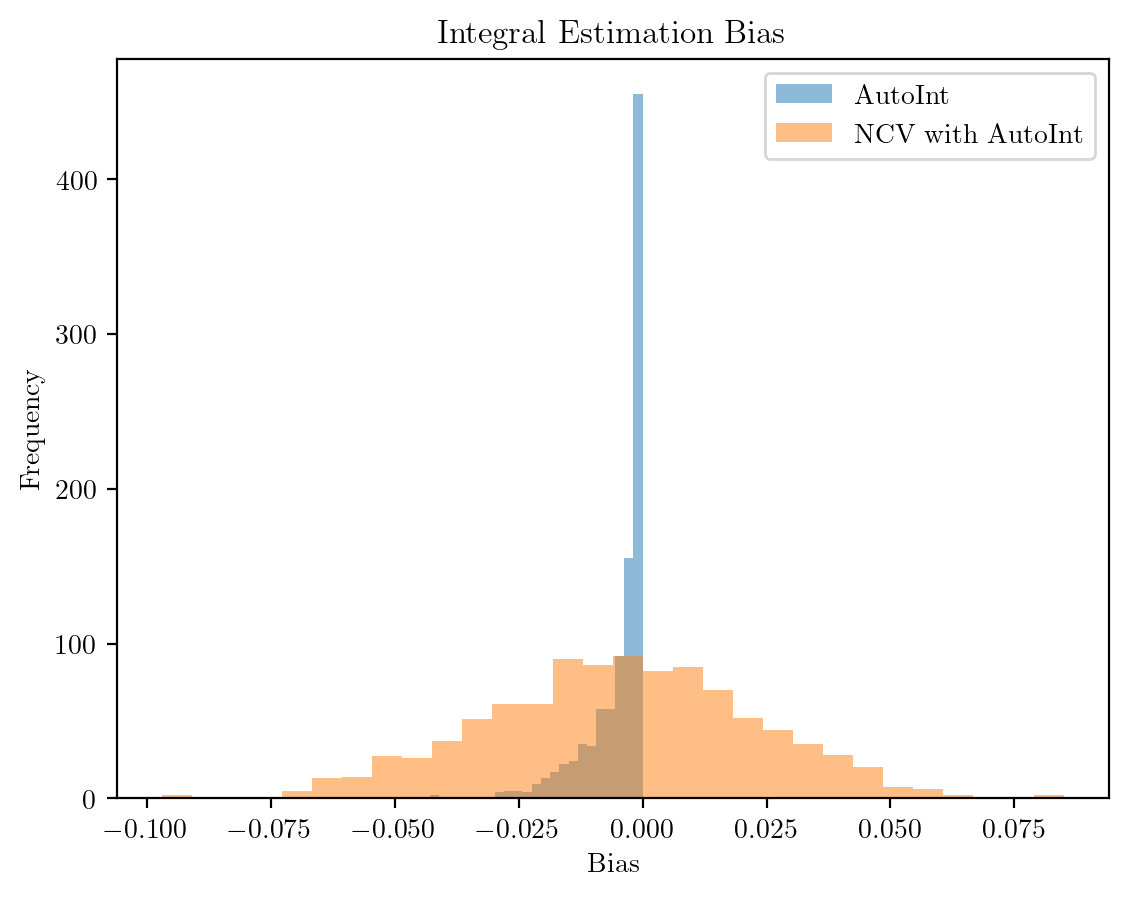

In [71]:
from matplotlib import pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure( dpi=200)
autoint_bias, ncv_bias = trials(true_value, runs=1000)
plt.hist(autoint_bias, bins=30, alpha=0.5, label='AutoInt')
plt.hist(ncv_bias, bins=30, alpha=0.5, label='NCV with AutoInt')
plt.legend(loc='upper right')
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.title('Integral Estimation Bias')
plt.show()


Text(0.5, 1.0, 'NCV + AutoInt Bias, f(x) = sin(x), N=10000, mean bias = 0.000238')

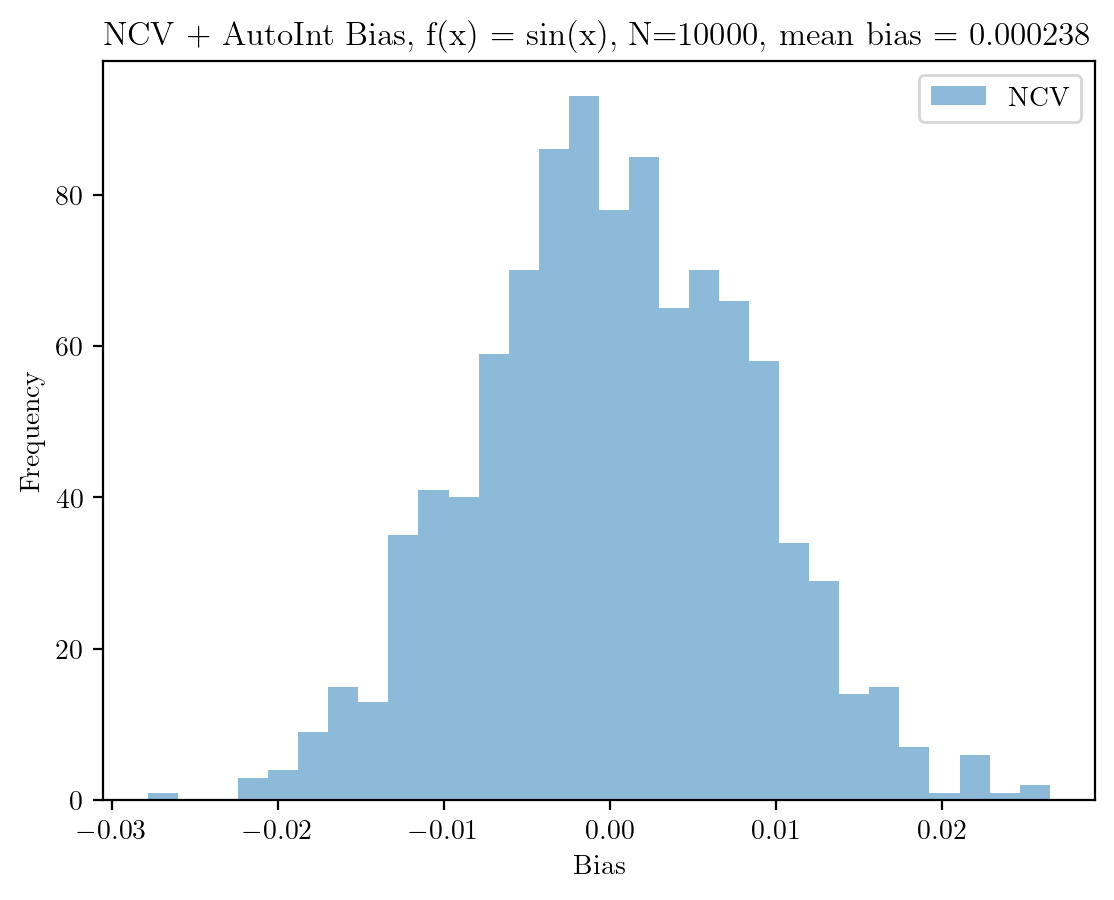

In [89]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure( dpi=200)
# autoint_bias, ncv_bias_10k = trials(runs=1000)
# plt.hist(autoint_bias, bins=30, alpha=0.5, label='AutoInt')
plt.hist(ncv_bias_10k, bins=30, alpha=0.5, label='NCV')
plt.legend(loc='upper right')
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.title(f'NCV + AutoInt Bias, f(x) = sin(x), N=10000, mean bias = {np.mean(ncv_bias_10k):7f}')
# plt.show()

